/Users/mnann/Documents/Code/AuthenticCursor/venvDev/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


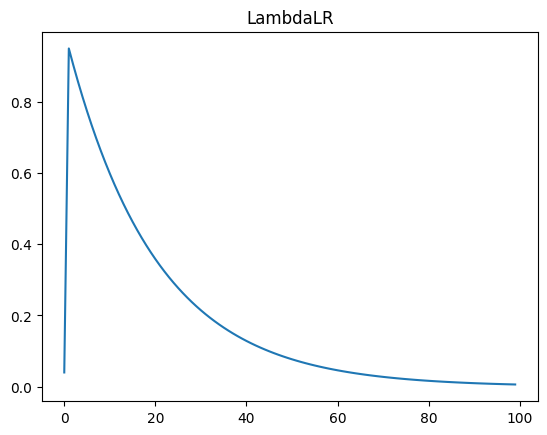

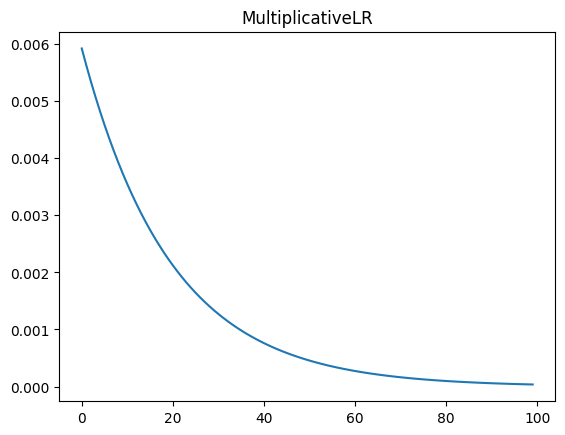

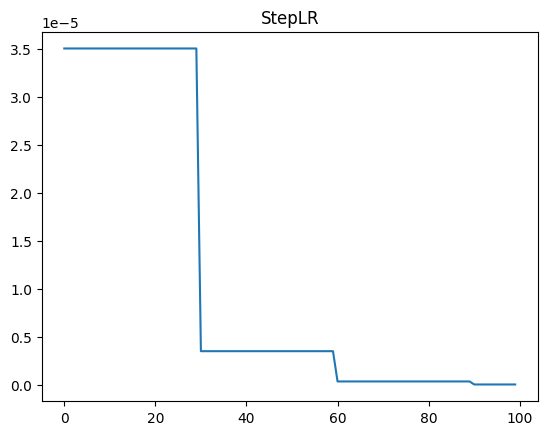

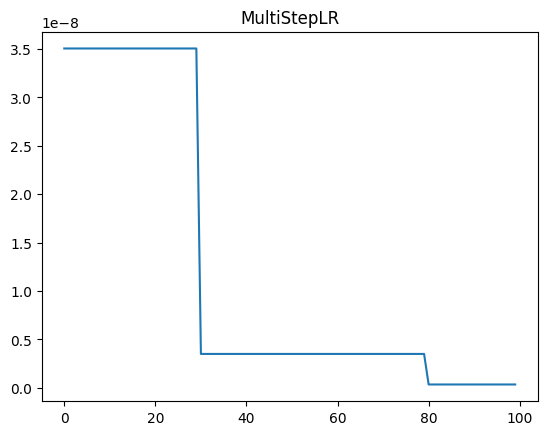

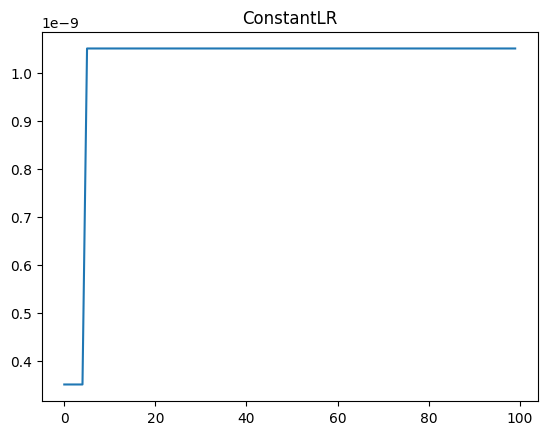

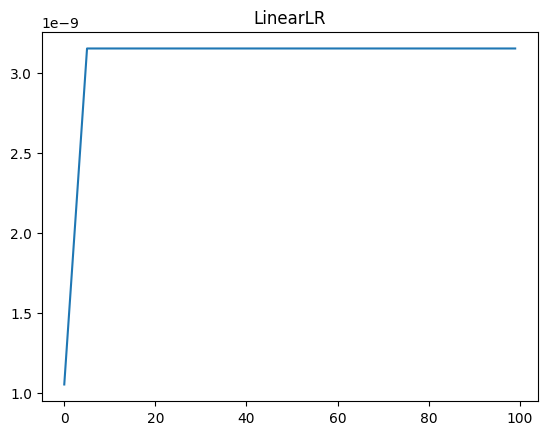

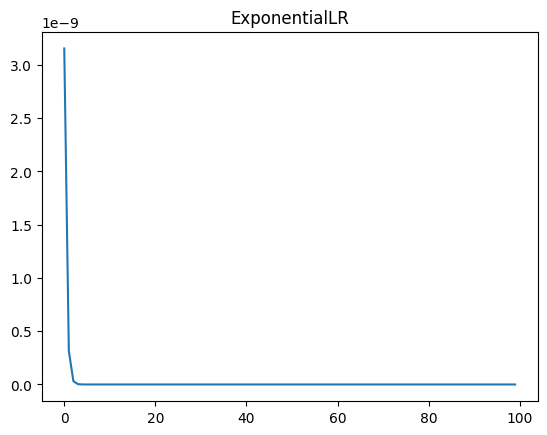

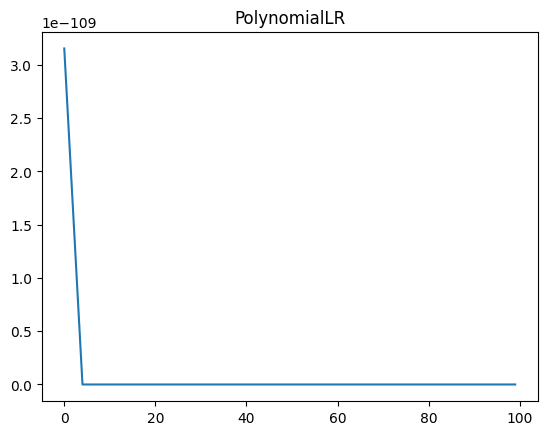

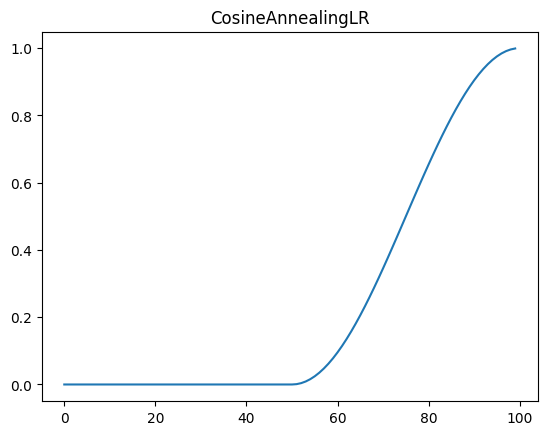

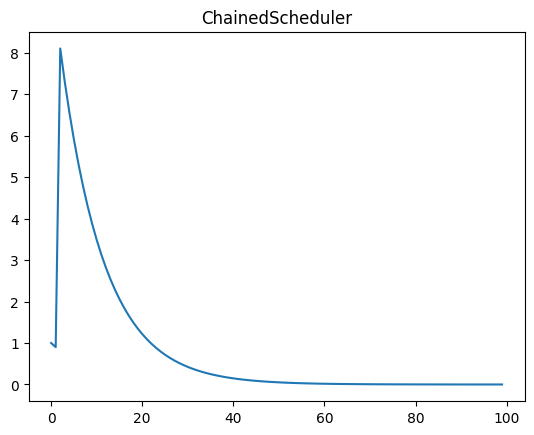

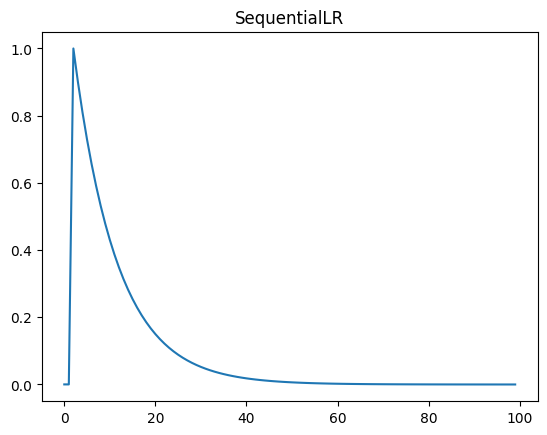

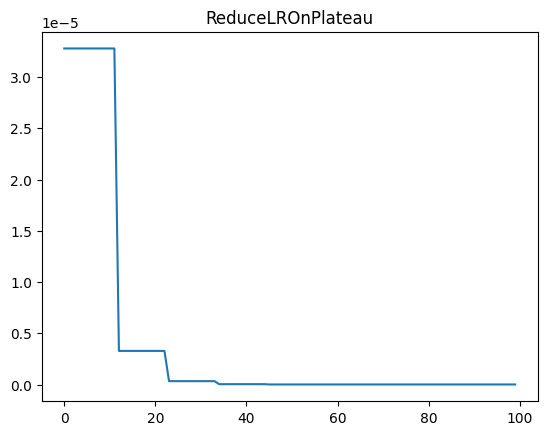

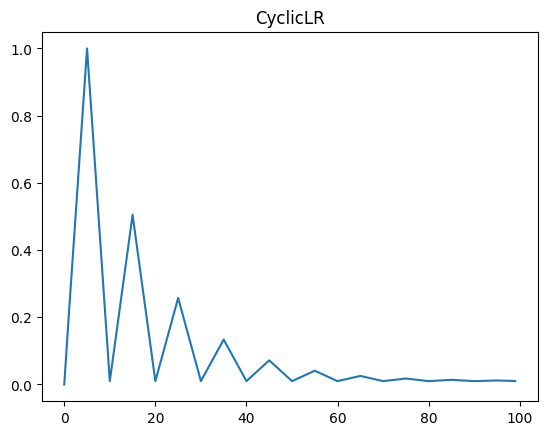

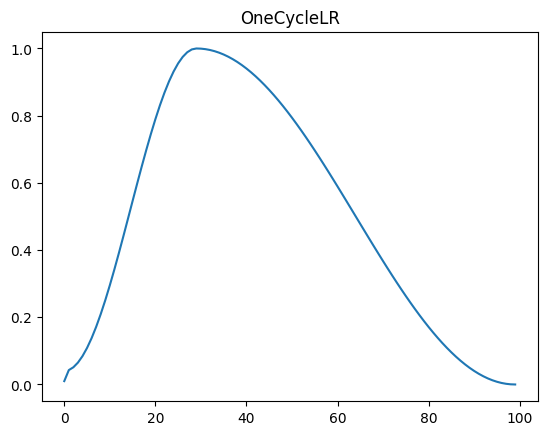

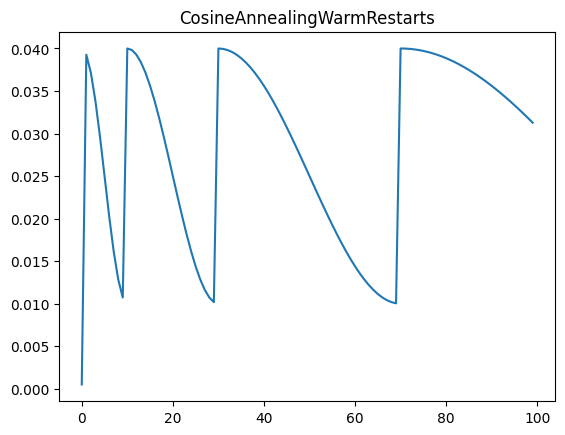

In [8]:
import torch
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Create an optimizer
optimizer = torch.optim.SGD([torch.randn(1, requires_grad=True)], lr=1)

# Define the number of epochs
num_epochs = 100
# Learning rate schedulers
schedulers = {
    "LambdaLR": lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch),
    "MultiplicativeLR": lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95),
    "StepLR": lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1),
    "MultiStepLR": lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1),
    "ConstantLR": lr_scheduler.ConstantLR(optimizer),
    "LinearLR" : lr_scheduler.LinearLR(optimizer),
    "ExponentialLR": lr_scheduler.ExponentialLR(optimizer, gamma=0.1),
    "PolynomialLR": lr_scheduler.PolynomialLR(optimizer,total_iters=4, power=1.0),
    "CosineAnnealingLR": lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0),
    "ChainedScheduler" : lr_scheduler.ChainedScheduler([lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=2), lr_scheduler.ExponentialLR(optimizer, gamma=0.9)]),
    "SequentialLR": lr_scheduler.SequentialLR(optimizer, schedulers=[lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=2), lr_scheduler.ExponentialLR(optimizer, gamma=0.9)], milestones=[2]),
    "ReduceLROnPlateau": lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
    "CyclicLR": lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=1, step_size_up=5, mode='triangular2'),
    "OneCycleLR": lr_scheduler.OneCycleLR(optimizer, max_lr=1, total_steps=num_epochs),
    "CosineAnnealingWarmRestarts": lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.01)
}

# Create a plot for each scheduler
for name, scheduler in schedulers.items():
    lrs = []
    for epoch in range(num_epochs):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        if name != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(epoch)  # Assume loss is decreasing with epoch for this example
        optimizer.zero_grad()

    plt.figure()
    plt.plot(lrs)
    plt.title(name)

plt.show()


In [7]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# import Variable
from torch.autograd import Variable

# Define Generator, Discriminator and Learning Rate Network
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class LRN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 1)  # assuming generator state is 100-dim vector

    def forward(self, x):
        return torch.sigmoid(self.fc(x))  # sigmoid to have learning rate between 0 and 1


# Initialize models and optimizers
G = Generator()
D = Discriminator()
LRN = LRN()

optimizer_G = optim.Adam(G.parameters(), lr=0.001)  # initialize with some learning rate
optimizer_D = optim.Adam(D.parameters(), lr=0.001)
optimizer_LRN = optim.Adam(LRN.parameters(), lr=0.001)

# Loss function
criterion = nn.BCELoss()

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(data, batch_size=32, shuffle=True)

num_epochs = 50

# Training Loop
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # with torch.autograd.set_detect_anomaly(True):
        real = Variable(torch.ones(imgs.size(0), 1))
        fake = Variable(torch.zeros(imgs.size(0), 1))
        real_imgs = Variable(imgs.view(imgs.size(0), -1))

        # Update Discriminator
        optimizer_D.zero_grad()
        z = Variable(torch.randn(imgs.size(0), 100))
        gen_imgs = G(z)
        real_loss = criterion(D(real_imgs), real)
        fake_loss = criterion(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Update Generator
        optimizer_G.zero_grad()
        z = Variable(torch.randn(imgs.size(0), 100))
        gen_imgs = G(z)
        g_loss = criterion(D(gen_imgs), real)
        g_loss.backward(retain_graph=True)
        optimizer_G.step()

        # Update LRN network
        optimizer_LRN.zero_grad()
        lr_loss = torch.abs(g_loss - LRN(torch.mean(z, dim=0)))
        lr_loss.backward()
        optimizer_LRN.step()

        # Update learning rate of G
        gen_state = torch.mean(z, dim=0)  # abstract the generator's state
        new_lr = LRN(gen_state).item()

        # Set the new learning rate
        for param_group in optimizer_G.param_groups:
            param_group['lr'] = new_lr

    print(f"Epoch: {epoch} | D_loss: {d_loss.item()} | G_loss: {g_loss.item()} | LR_loss: {lr_loss.item()} | New LR: {new_lr}")


KeyboardInterrupt: 